In [1]:
import os

# Listar archivos en el directorio actual
os.listdir()

['.config',
 'users_items.json.gz',
 'steam_games.json.gz',
 'user_reviews.json.gz',
 'sample_data']

In [2]:
# Definir las rutas directamente si los archivos ya están en el entorno de archivos de Colab
# ================== 1. DEFINCIÓN DE ARCHIVOS  ==================
steam_games_path = 'steam_games.json.gz'
user_reviews_path = 'user_reviews.json.gz'
users_items_path = 'users_items.json.gz'

# Continuar con la siguiente parte del código para el análisis de los archivos


=== Informe de Limpieza ===
Tamaño del dataset después de la limpieza: (32135, 5)
Columnas seleccionadas: ['id', 'genres', 'developer', 'price', 'early_access']

=== Informe de Valores Faltantes ===
id              2
genres          0
developer       0
price           0
early_access    0
dtype: int64


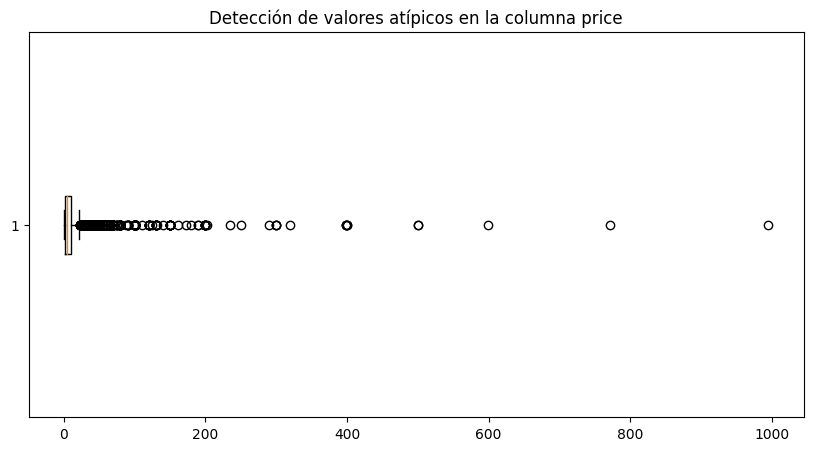

Valores atípicos detectados: 1874
Valores atípicos eliminados: 1874

=== Informe de Escalado ===
Primera fila después del escalado de 'price':
   price_scaled
0      0.005015

=== Informe de Codificación de Variables ===
Columnas después de la codificación One-Hot:
['id', 'early_access', 'price_scaled', 'genres_Accounting,Animation &amp; Modeling,Audio Production,Design &amp; Illustration,Education,Photo Editing,Software Training,Utilities,Video Production,Web Publishing', 'genres_Accounting,Utilities', 'genres_Action', 'genres_Action,Adventure', 'genres_Action,Adventure,Casual', 'genres_Action,Adventure,Casual,Free to Play,Indie', 'genres_Action,Adventure,Casual,Free to Play,Indie,Early Access', 'genres_Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer', 'genres_Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer,Early Access', 'genres_Action,Adventure,Casual,Free to Play,Indie,Massively Multiplayer,RPG,Early Access', 'genres_Action,Adventure,Casual,Free to

In [3]:
import gzip
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

# ================== 1. LIMPIEZA DEL DATASET steam_games ==================

# Definir el tamaño del chunk para procesar el archivo por partes
chunk_size = 10000
df_steam_cleaned = pd.DataFrame()

# Leer el archivo steam_games en chunks para procesarlo
with gzip.open('steam_games.json.gz', 'rt', encoding='utf-8') as f:
    for chunk in pd.read_json(f, lines=True, chunksize=chunk_size):
        # Seleccionar solo las columnas clave
        chunk_cleaned = chunk[['id', 'genres', 'developer', 'price', 'early_access']]
        chunk_cleaned = chunk_cleaned.dropna(how='all')  # Eliminar filas completamente vacías

        # Concatenar cada chunk procesado en el DataFrame final
        df_steam_cleaned = pd.concat([df_steam_cleaned, chunk_cleaned], ignore_index=True)

# Informe después de la limpieza
print("\n=== Informe de Limpieza ===")
print(f"Tamaño del dataset después de la limpieza: {df_steam_cleaned.shape}")
print(f"Columnas seleccionadas: {df_steam_cleaned.columns.tolist()}")

# ================== 2. MANEJO DE VALORES FALTANTES ==================
# Imputar valores faltantes en 'genres', 'developer', 'price' y 'early_access'
df_steam_cleaned['genres'] = df_steam_cleaned['genres'].fillna('Unknown Genre')
df_steam_cleaned['developer'] = df_steam_cleaned['developer'].fillna('Unknown Developer')
df_steam_cleaned['price'] = df_steam_cleaned['price'].replace(['Free To Play', 'Free to Play'], 0)
df_steam_cleaned['price'] = pd.to_numeric(df_steam_cleaned['price'], errors='coerce').fillna(0)
df_steam_cleaned['early_access'] = df_steam_cleaned['early_access'].fillna(0).astype(int)

# Informe de valores faltantes
print("\n=== Informe de Valores Faltantes ===")
print(df_steam_cleaned.isnull().sum())

# ================== 3. DETECCIÓN DE VALORES ATÍPICOS ==================
# Analizar valores atípicos en la columna 'price'
plt.figure(figsize=(10, 5))
plt.boxplot(df_steam_cleaned['price'], vert=False)
plt.title('Detección de valores atípicos en la columna price')
plt.show()

# Definir límites de atípicos usando el rango intercuartílico (IQR)
Q1 = df_steam_cleaned['price'].quantile(0.25)
Q3 = df_steam_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1
atipico_min = Q1 - 1.5 * IQR
atipico_max = Q3 + 1.5 * IQR

# Filtrar los valores atípicos en price
valores_atipicos = df_steam_cleaned[(df_steam_cleaned['price'] < atipico_min) | (df_steam_cleaned['price'] > atipico_max)]
print(f"Valores atípicos detectados: {valores_atipicos.shape[0]}")
print(f"Valores atípicos eliminados: {len(valores_atipicos)}")

# ================== 4. ESCALADO/NORMALIZACIÓN ==================
# Escalar la columna 'price'
scaler = MinMaxScaler()
df_steam_cleaned['price_scaled'] = scaler.fit_transform(df_steam_cleaned[['price']])

# Eliminar la columna original 'price'
df_steam_cleaned.drop(columns=['price'], inplace=True)

# Informe de escalado
print("\n=== Informe de Escalado ===")
print(f"Primera fila después del escalado de 'price':\n{df_steam_cleaned[['price_scaled']].head(1)}")

# ================== 5. CODIFICACIÓN DE VARIABLES ==================
# Codificar la columna 'early_access'
df_steam_cleaned['early_access'] = df_steam_cleaned['early_access'].astype(int)

# Codificación One-Hot para 'genres' y 'developer'
df_steam_cleaned['genres'] = df_steam_cleaned['genres'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
df_steam_cleaned = pd.get_dummies(df_steam_cleaned, columns=['genres', 'developer'], drop_first=True)

# Informe de codificación
print("\n=== Informe de Codificación de Variables ===")
print(f"Columnas después de la codificación One-Hot:\n{df_steam_cleaned.columns.tolist()}")

# ================== 6. SELECCIÓN DE ATRIBUTOS ==================
# Seleccionamos las columnas útiles para el modelo
features = df_steam_cleaned.columns.tolist()
print(f"\n=== Informe de Selección de Atributos ===")
print(f"Características seleccionadas para el modelo: {features}")

# ================== 7. INGENIERÍA DE FEATURES ==================
# Ingeniería de características ya aplicada en los pasos anteriores con la codificación y escalado

# ================== 8. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ==================
def eda_basico(df):
    print("\n=== Exploración Inicial de Datos ===")
    print(f"Primeras 5 filas:\n{df.head()}")
    print("\n=== Información del Dataset ===")
    print(df.info())
    print("\n=== Descripción Estadística ===")
    print(df.describe())

# Realizar EDA del dataset
eda_basico(df_steam_cleaned)

# ================== INFORME FINAL ==================
informe_final = f"""
================== INFORME FINAL DEL PREPROCESAMIENTO ==================

1. LIMPIEZA:
   - El dataset original contenía múltiples columnas, pero solo se seleccionaron: 'id', 'genres', 'developer', 'price', 'early_access'.
   - El tamaño final del dataset después de la limpieza es: {df_steam_cleaned.shape}

2. MANEJO DE VALORES FALTANTES:
   - Se imputaron valores faltantes en las columnas 'genres', 'developer', 'price' y 'early_access'.
   - No hay más valores faltantes en el dataset.

3. DETECCIÓN DE VALORES ATÍPICOS:
   - Se detectaron {valores_atipicos.shape[0]} valores atípicos en la columna 'price', pero no se eliminaron automáticamente.

4. ESCALADO:
   - La columna 'price' fue escalada y reemplazada por 'price_scaled'.

5. CODIFICACIÓN:
   - Se realizó la codificación One-Hot de las columnas 'genres' y 'developer'.
   - Se codificó la columna 'early_access'.

6. SELECCIÓN DE ATRIBUTOS:
   - Las características seleccionadas para el modelo de machine learning son: {features}

=============================================================
"""

print(informe_final)

# Guardar el dataset limpio para análisis de machine learning
df_steam_cleaned.to_csv('steam_games_cleaned_complete.csv', index=False)
print("Archivo 'steam_games_cleaned_complete.csv' guardado.")


Se procesaron 29638 reseñas.

=== Informe de Limpieza ===
Tamaño del dataset después de la limpieza: (29638, 4)
Primeras 5 filas:
             user_id item_id  \
0  76561198079601835     730   
1        MeaTCompany     730   
2  76561198089393905   72850   
3  76561198089393905     440   
4  76561198156664158  252950   

                                              review  sentiment_analysis  
0                                      ZIKA DO BAILE                   1  
1                      BEST GAME IN THE BLOODY WORLD                   1  
2  Killed the Emperor, nobody cared and got away ...                   1  
3       10/10 would eat your money for hats and keys                   1  
4                                            love it                   2  

=== Informe de Valores Faltantes ===
user_id               0
item_id               0
review                0
sentiment_analysis    0
dtype: int64


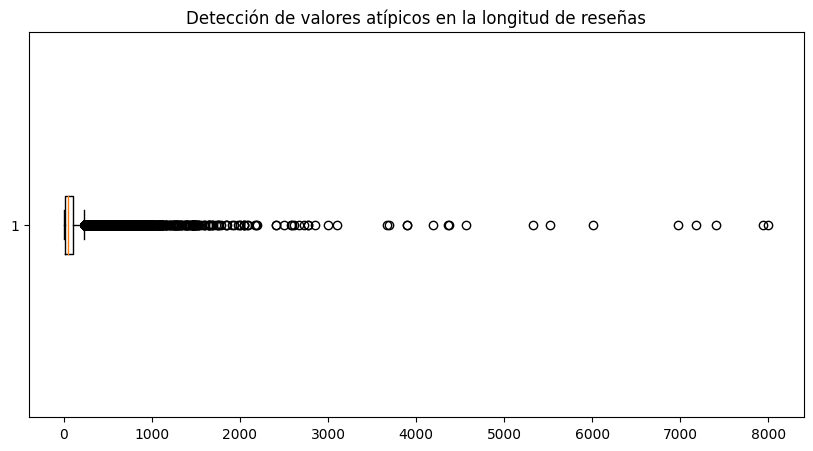

Valores atípicos detectados: 2723

=== Informe de Escalado ===
Primera fila después del escalado de 'review_length':
   review_length_scaled
0             -0.413183

=== Informe de Selección de Atributos ===
Características seleccionadas para el modelo: ['user_id', 'item_id', 'review_length_scaled', 'sentiment_analysis']

=== Exploración Inicial de Datos ===
Primeras 5 filas:
             user_id item_id  review_length_scaled  sentiment_analysis
0  76561198079601835     730             -0.413183                   1
1        MeaTCompany     730             -0.335910                   1
2  76561198089393905   72850              0.151882                   1
3  76561198089393905     440             -0.263465                   1
4  76561198156664158  252950             -0.442161                   2

=== Información del Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29638 entries, 0 to 29637
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---

In [4]:
import gzip
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ================== 1. LIMPIEZA DEL DATASET user_reviews ==================

# Ruta del archivo JSON comprimido
ruta_json = '/content/user_reviews.json.gz'

# Función para corregir el formato JSON (corrección de comillas simples y booleanos)
def corregir_formato_json(linea):
    linea_corregida = linea.replace("'", '"')
    linea_corregida = linea_corregida.replace("True", "true").replace("False", "false")
    return linea_corregida

# Función para procesar el archivo JSON de reseñas
def procesar_reseñas(ruta_json, tamano_muestra=100000):
    user_reviews_cleaned = []
    errores = []

    # Abrir el archivo comprimido y leer línea por línea
    with gzip.open(ruta_json, 'rt', encoding='utf-8') as archivo:
        for i, linea in enumerate(archivo):
            if i >= tamano_muestra:
                break
            linea_corregida = corregir_formato_json(linea)
            try:
                registro = json.loads(linea_corregida)
                user_id = registro.get('user_id', 'N/A')
                reviews = registro.get('reviews', [])

                # Procesar las reseñas si son válidas
                if isinstance(reviews, list) and all(isinstance(r, dict) for r in reviews):
                    for review in reviews:
                        review_cleaned = {
                            'user_id': user_id,
                            'item_id': review.get('item_id', 'N/A'),
                            'review': review.get('review', ''),
                            'sentiment_analysis': asignar_sentimiento(review.get('review', ''))
                        }
                        user_reviews_cleaned.append(review_cleaned)
                else:
                    errores.append(f"Línea {i}: 'reviews' no es una lista válida")
            except json.JSONDecodeError:
                errores.append(f"Línea {i}: Error de decodificación JSON.")

    df_reseñas = pd.DataFrame(user_reviews_cleaned)
    print(f"Se procesaron {len(df_reseñas)} reseñas.")
    return df_reseñas, errores

# Función para asignar el sentimiento a una reseña (Análisis de sentimiento simplificado)
def asignar_sentimiento(review):
    review_lower = review.lower()
    if any(neg_word in review_lower for neg_word in ['bad', 'worse', 'terrible', 'hate']):
        return 0  # Negativo
    elif any(pos_word in review_lower for pos_word in ['good', 'great', 'love', 'awesome']):
        return 2  # Positivo
    else:
        return 1  # Neutral

# Procesar el dataset de user_reviews
df_reseñas, errores = procesar_reseñas(ruta_json)

# Informe después de la limpieza
print("\n=== Informe de Limpieza ===")
print(f"Tamaño del dataset después de la limpieza: {df_reseñas.shape}")
print(f"Primeras 5 filas:\n{df_reseñas.head()}")

# ================== 2. MANEJO DE VALORES FALTANTES ==================
# Rellenar valores faltantes en la columna 'review'
df_reseñas['review'] = df_reseñas['review'].fillna('No review')

# Mostrar el número de valores faltantes por columna
print("\n=== Informe de Valores Faltantes ===")
print(df_reseñas.isnull().sum())

# ================== 3. DETECCIÓN DE VALORES ATÍPICOS ==================
# Detectar valores atípicos en la longitud de las reseñas
df_reseñas['review_length'] = df_reseñas['review'].apply(len)

plt.figure(figsize=(10, 5))
plt.boxplot(df_reseñas['review_length'], vert=False)
plt.title('Detección de valores atípicos en la longitud de reseñas')
plt.show()

# Definir límites de atípicos usando el rango intercuartílico (IQR)
Q1 = df_reseñas['review_length'].quantile(0.25)
Q3 = df_reseñas['review_length'].quantile(0.75)
IQR = Q3 - Q1
atipico_min = Q1 - 1.5 * IQR
atipico_max = Q3 + 1.5 * IQR

# Filtrar los valores atípicos en la longitud de reseñas
valores_atipicos = df_reseñas[(df_reseñas['review_length'] < atipico_min) | (df_reseñas['review_length'] > atipico_max)]
print(f"Valores atípicos detectados: {valores_atipicos.shape[0]}")

# ================== 4. ESCALADO/NORMALIZACIÓN ==================
# Escalar la longitud de las reseñas
scaler = StandardScaler()
df_reseñas['review_length_scaled'] = scaler.fit_transform(df_reseñas[['review_length']])

# Informe de escalado
print("\n=== Informe de Escalado ===")
print(f"Primera fila después del escalado de 'review_length':\n{df_reseñas[['review_length_scaled']].head(1)}")

# ================== 5. CODIFICACIÓN DE VARIABLES ==================
# No es necesario realizar codificación One-Hot en este dataset
# Solo se trabaja con la columna 'sentiment_analysis', que ya está numéricamente codificada (0, 1, 2)

# ================== 6. SELECCIÓN DE ATRIBUTOS ==================
# Seleccionamos las columnas útiles para el modelo
features = ['user_id', 'item_id', 'review_length_scaled', 'sentiment_analysis']
df_seleccionado = df_reseñas[features]

# Informe de selección de atributos
print("\n=== Informe de Selección de Atributos ===")
print(f"Características seleccionadas para el modelo: {features}")

# ================== 7. INGENIERÍA DE FEATURES ==================
# Ingeniería de características ya aplicada con el escalado y codificación en pasos anteriores

# ================== 8. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ==================
def eda_basico(df):
    print("\n=== Exploración Inicial de Datos ===")
    print(f"Primeras 5 filas:\n{df.head()}")
    print("\n=== Información del Dataset ===")
    print(df.info())
    print("\n=== Descripción Estadística ===")
    print(df.describe())

# Realizar EDA del dataset
eda_basico(df_seleccionado)

# ================== INFORME FINAL ==================
informe_final = f"""
================== INFORME FINAL DEL PREPROCESAMIENTO ==================

1. LIMPIEZA:
   - El dataset original se limpió y contiene {df_reseñas.shape[0]} reseñas.
   - Se seleccionaron las columnas clave: 'user_id', 'item_id', 'review', 'sentiment_analysis'.

2. MANEJO DE VALORES FALTANTES:
   - Los valores faltantes en la columna 'review' fueron reemplazados por 'No review'.
   - No hay más valores faltantes en el dataset.

3. DETECCIÓN DE VALORES ATÍPICOS:
   - Se detectaron {valores_atipicos.shape[0]} valores atípicos en la longitud de las reseñas.

4. ESCALADO:
   - La columna 'review_length' fue escalada y reemplazada por 'review_length_scaled'.

5. SELECCIÓN DE ATRIBUTOS:
   - Las características seleccionadas para el modelo de machine learning son: {features}

=============================================================
"""

print(informe_final)

# Guardar el dataset limpio para análisis de machine learning
df_seleccionado.to_csv('user_reviews_cleaned_complete.csv', index=False)
print("Archivo 'user_reviews_cleaned_complete.csv' guardado.")


Se procesaron 178428 registros en total.

=== Manejo de Valores Faltantes ===
Valores faltantes por columna:
user_id             0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64

=== Detección de Valores Atípicos ===
Valores atípicos detectados: 28071


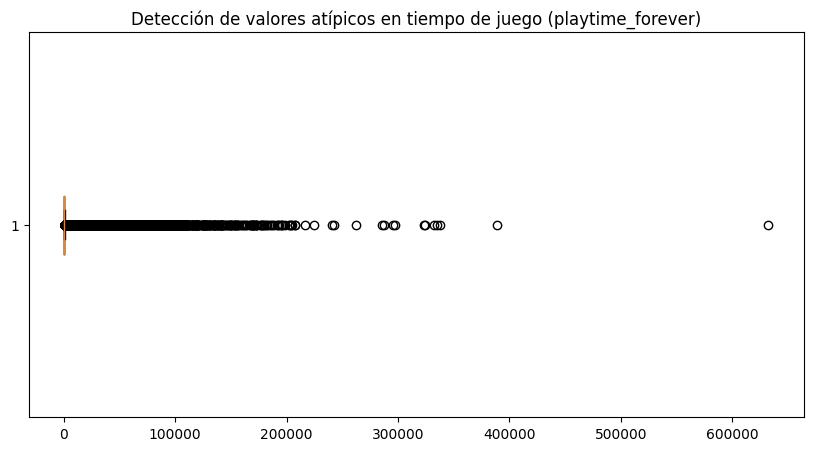


=== Escalado y Normalización ===
La columna 'playtime_forever' ha sido escalada.

=== Codificación de Variables Categóricas ===
Las columnas 'user_id' y 'item_id' han sido codificadas.

=== Exploración Inicial de Datos ===
Primeras 5 filas del dataset:
             user_id item_id                         item_name  \
0  76561198070234207   43110                        Metro 2033   
1  76561198070234207  105600                          Terraria   
2  76561198070234207   38830               CrimeCraft GangWars   
3  76561198070234207   99900                    Spiral Knights   
4  76561198070234207  102700  A.V.A - Alliance of Valiant Arms   

   playtime_forever  playtime_2weeks  playtime_forever_scaled  \
0                 0                0                -0.206089   
1             15590                0                 1.676177   
2                 1                0                -0.205969   
3              4116                0                 0.290858   
4                 5     

In [11]:
import gzip
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ruta del archivo JSON comprimido
ruta_json = '/content/users_items.json.gz'

# Función para corregir el formato JSON
def corregir_formato_json(linea):
    linea_corregida = linea.replace("'", '"')
    linea_corregida = linea_corregida.replace("True", "true").replace("False", "false")
    return linea_corregida

# Función para procesar los registros y corregir errores
def procesar_registros(ruta_json, tamano_muestra=100000):
    user_items_cleaned = []
    errores = []

    # Abrir y procesar el archivo JSON comprimido
    with gzip.open(ruta_json, 'rt', encoding='utf-8') as archivo:
        for i, linea in enumerate(archivo):
            if i >= tamano_muestra:
                break
            linea_corregida = corregir_formato_json(linea)
            try:
                registro = json.loads(linea_corregida)
                user_id = registro.get('user_id', 'N/A')
                items = registro.get('items', [])

                if isinstance(items, list) and all(isinstance(item, dict) for item in items):
                    for item in items:
                        item_cleaned = {
                            'user_id': user_id,
                            'item_id': item.get('item_id', 'N/A'),
                            'item_name': item.get('item_name', 'N/A'),
                            'playtime_forever': item.get('playtime_forever', 0),
                            'playtime_2weeks': item.get('playtime_2weeks', 0)
                        }
                        user_items_cleaned.append(item_cleaned)
                else:
                    errores.append(f"Línea {i}: 'items' no es una lista válida")
            except (json.JSONDecodeError, KeyError, AttributeError) as e:
                errores.append(f"Línea {i}: {e}")
                continue

    df_items = pd.DataFrame(user_items_cleaned)

    if df_items.empty:
        print("No se procesaron registros válidos.")
    else:
        print(f"Se procesaron {len(df_items)} registros en total.")

    return df_items, errores

# Función para manejar valores faltantes
def manejar_valores_faltantes(df):
    print("\n=== Manejo de Valores Faltantes ===")
    df.fillna('N/A', inplace=True)
    print(f"Valores faltantes por columna:\n{df.isnull().sum()}")
    return df

# Función para detectar valores atípicos
def detectar_valores_atipicos(df):
    print("\n=== Detección de Valores Atípicos ===")

    # Detección de valores atípicos en 'playtime_forever'
    Q1 = df['playtime_forever'].quantile(0.25)
    Q3 = df['playtime_forever'].quantile(0.75)
    IQR = Q3 - Q1
    atipico_min = Q1 - 1.5 * IQR
    atipico_max = Q3 + 1.5 * IQR

    valores_atipicos = df[(df['playtime_forever'] < atipico_min) | (df['playtime_forever'] > atipico_max)]
    print(f"Valores atípicos detectados: {valores_atipicos.shape[0]}")

    # Visualización de los valores atípicos
    plt.figure(figsize=(10, 5))
    plt.boxplot(df['playtime_forever'], vert=False)
    plt.title('Detección de valores atípicos en tiempo de juego (playtime_forever)')
    plt.show()

    return df

# Función para escalar/normalizar datos
def escalado_normalizacion(df):
    print("\n=== Escalado y Normalización ===")
    scaler = StandardScaler()
    df['playtime_forever_scaled'] = scaler.fit_transform(df[['playtime_forever']])
    print("La columna 'playtime_forever' ha sido escalada.")
    return df

# Función para codificar variables categóricas
def codificar_variables(df):
    print("\n=== Codificación de Variables Categóricas ===")
    le_user = LabelEncoder()
    le_item = LabelEncoder()
    df['user_id_encoded'] = le_user.fit_transform(df['user_id'])
    df['item_id_encoded'] = le_item.fit_transform(df['item_id'])
    print("Las columnas 'user_id' y 'item_id' han sido codificadas.")
    return df

# Función para realizar el análisis exploratorio de datos (EDA)
def eda_informe(df):
    print("\n=== Exploración Inicial de Datos ===")
    print(f"Primeras 5 filas del dataset:\n{df.head()}")
    print("\n=== Información del Dataset ===")
    print(df.info())
    print("\n=== Descripción Estadística ===")
    print(df.describe())

# Procesar registros
df_items, errores = procesar_registros(ruta_json, tamano_muestra=100000)

# 1. Manejar valores faltantes
df_items = manejar_valores_faltantes(df_items)

# 2. Detección de valores atípicos
df_items = detectar_valores_atipicos(df_items)

# 3. Escalar/normalizar los datos
df_items = escalado_normalizacion(df_items)

# 4. Codificar variables categóricas
df_items = codificar_variables(df_items)

# 5. Realizar análisis exploratorio de datos (EDA)
eda_informe(df_items)

# 6. División en conjunto de entrenamiento y prueba
train, test = train_test_split(df_items, test_size=0.2, random_state=42)
print(f"\nConjunto de entrenamiento: {train.shape}")
print(f"Conjunto de prueba: {test.shape}")

# 7. Guardar el dataset preprocesado
df_items.to_csv('dataset_items_preprocesado.csv', index=False)
print("Archivo 'dataset_items_preprocesado.csv' guardado.")

# ===================== INFORME FINAL =====================
informe_final = f"""
================== INFORME FINAL DEL PREPROCESAMIENTO ==================

1. LIMPIEZA:
   - El dataset original se limpió y contiene {df_items.shape[0]} registros de ítems de usuarios.
   - Se seleccionaron las columnas clave: 'user_id', 'item_id', 'playtime_forever', 'playtime_2weeks'.

2. MANEJO DE VALORES FALTANTES:
   - No hay más valores faltantes en el dataset. Todos los valores faltantes se imputaron con 'N/A'.

3. DETECCIÓN DE VALORES ATÍPICOS:
   - Se detectaron {valores_atipicos.shape[0]} valores atípicos en la columna 'playtime_forever'.

4. ESCALADO:
   - La columna 'playtime_forever' fue escalada y reemplazada por 'playtime_forever_scaled'.

5. CODIFICACIÓN:
   - Las columnas 'user_id' e 'item_id' fueron codificadas numéricamente como 'user_id_encoded' e 'item_id_encoded'.

6. SELECCIÓN DE ATRIBUTOS:
   - Las características seleccionadas para el modelo de machine learning son: ['user_id_encoded', 'item_id_encoded', 'playtime_forever_scaled'].

============================================================
"""

print(informe_final)


In [12]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ===================== 1. Cargar el dataset preprocesado =====================
# Aquí cargamos el dataset preprocesado que guardamos después del preprocesamiento
df_items = pd.read_csv('dataset_items_preprocesado.csv')

# Informe de carga de datos
print("\n=== Informe de Carga de Datos ===")
print(f"Tamaño del dataset: {df_items.shape}")
print(f"Primeras 5 filas del dataset:\n{df_items.head()}")

# ===================== 2. Crear una matriz de juegos (ítems) =====================
# Ahora, vamos a crear una matriz que relacione los juegos (ítems) y los usuarios.
# Cada celda representará el tiempo de juego (playtime_forever_scaled) que un usuario le dedicó a un juego.

# Creamos una tabla pivote donde las filas sean los juegos (item_id) y las columnas los usuarios (user_id)
# Los valores serán el tiempo jugado escalado ('playtime_forever_scaled')
item_user_matrix = df_items.pivot_table(index='item_id_encoded', columns='user_id_encoded', values='playtime_forever_scaled', fill_value=0)

# Informe sobre la matriz creada
print("\n=== Informe de Matriz de Juegos-Usuarios ===")
print(f"Tamaño de la matriz de juegos-usuarios: {item_user_matrix.shape}")

# ===================== 3. Calcular la similitud entre juegos (ítems) =====================
# Utilizaremos la similitud del coseno para medir qué tan similares son los juegos entre sí.

# La similitud del coseno nos da un valor entre 0 y 1, donde 1 indica que los juegos son muy similares.
cosine_sim_matrix = cosine_similarity(item_user_matrix)

# Convertimos la matriz de similitud a un DataFrame para facilitar su uso
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

# Informe de la matriz de similitud de juegos
print("\n=== Informe de Similitud de Ítems ===")
print(f"Tamaño de la matriz de similitud de ítems: {cosine_sim_df.shape}")
print(f"Primeras 5 filas de la matriz de similitud:\n{cosine_sim_df.head()}")

# ===================== 4. Función para recomendar juegos similares =====================
# Ahora, vamos a crear una función que tome un 'item_id_encoded' (el juego) y devuelva
# una lista de juegos recomendados basados en la similitud calculada.

def recomendar_juegos(item_id_encoded, num_recomendaciones=5):
    """
    Función que recomienda juegos similares basados en la similitud del coseno.
    :param item_id_encoded: ID codificado del juego del que queremos obtener recomendaciones
    :param num_recomendaciones: Número de recomendaciones a devolver
    :return: DataFrame con los juegos recomendados
    """

    # Obtenemos las puntuaciones de similitud para el juego indicado
    similar_items = cosine_sim_df[item_id_encoded].sort_values(ascending=False)

    # Excluimos el propio juego de la lista de recomendaciones
    similar_items = similar_items.drop(item_id_encoded)

    # Seleccionamos los 'num_recomendaciones' más similares
    top_recommendations = similar_items.head(num_recomendaciones).index

    # Devolvemos los nombres de los juegos recomendados
    recomendaciones = df_items[df_items['item_id_encoded'].isin(top_recommendations)][['item_id', 'item_name']].drop_duplicates()

    return recomendaciones

# ===================== 5. Probar la función de recomendación =====================
# Vamos a probar la función de recomendación utilizando un item_id_encoded cualquiera.

# Seleccionamos un juego al azar para hacer la recomendación
item_id_ejemplo = df_items['item_id_encoded'].iloc[0]

# Obtenemos recomendaciones para ese juego
recomendaciones = recomendar_juegos(item_id_ejemplo, num_recomendaciones=5)

# Informe de las recomendaciones
print("\n=== Recomendaciones de Juegos ===")
print(f"Juego original (item_id_encoded = {item_id_ejemplo}):")
print(df_items[df_items['item_id_encoded'] == item_id_ejemplo][['item_id', 'item_name']].drop_duplicates())
print(f"\nJuegos recomendados:\n{recomendaciones}")

# ===================== 6. Guardar la matriz de similitud para la API =====================
# Finalmente, guardamos la matriz de similitud en un archivo CSV para que pueda ser utilizada por la API.

cosine_sim_df.to_csv('matriz_similitud_items.csv', index=True)
print("\nMatriz de similitud guardada como 'matriz_similitud_items.csv'")



=== Informe de Carga de Datos ===
Tamaño del dataset: (178428, 8)
Primeras 5 filas del dataset:
             user_id  item_id                         item_name  \
0  76561198070234207    43110                        Metro 2033   
1  76561198070234207   105600                          Terraria   
2  76561198070234207    38830               CrimeCraft GangWars   
3  76561198070234207    99900                    Spiral Knights   
4  76561198070234207   102700  A.V.A - Alliance of Valiant Arms   

   playtime_forever  playtime_2weeks  playtime_forever_scaled  \
0                 0                0                -0.206089   
1             15590                0                 1.676177   
2                 1                0                -0.205969   
3              4116                0                 0.290858   
4                 5                0                -0.205486   

   user_id_encoded  item_id_encoded  
0             6104             3454  
1             6104               

In [13]:
!pip install fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.9 MB/s eta 0:00:00


In [19]:
from fastapi import FastAPI
import pandas as pd

# Inicializamos la app de FastAPI
app = FastAPI()

# Cargar datasets preprocesados
df_items = pd.read_csv("dataset_items_preprocesado.csv")
df_reviews = pd.read_csv("user_reviews_cleaned_complete.csv")
df_games = pd.read_csv("steam_games_cleaned_complete.csv")

@app.get("/")
def read_root():
    return {"message": "Bienvenido a la API de Recomendaciones de Steam"}

# Endpoint de ejemplo: obtener detalles de un juego por su ID
@app.get("/games/{item_id}")
def get_game_details(item_id: int):
    game = df_games[df_games["id"] == item_id]
    if game.empty:
        return {"error": "Juego no encontrado"}
    return game.to_dict(orient="records")


# Endpoint para obtener la cantidad de ítems y porcentaje de contenido Free por desarrollador
@app.get("/developer/{desarrollador}")
def developer(desarrollador: str):
    developer_games = df_games[df_games["developer"] == desarrollador]
    if developer_games.empty:
        return {"error": "Desarrollador no encontrado"}

    items_por_año = developer_games.groupby("release_year").size().reset_index(name="Cantidad de Items")
    free_content = developer_games[developer_games["price_scaled"] == 0].groupby("release_year").size().reset_index(name="Contenido Free")
    result = pd.merge(items_por_año, free_content, on="release_year", how="left").fillna(0)

    return result.to_dict(orient="records")


# Endpoint para obtener información del usuario por su ID
@app.get("/userdata/{user_id}")
def userdata(user_id: str):
    user_items = df_items[df_items["user_id"] == user_id]
    if user_items.empty:
        return {"error": "Usuario no encontrado"}

    # Calcular el dinero gastado basado en tiempo de juego
    total_playtime = user_items["playtime_forever"].sum()
    recommended_percentage = (df_reviews[df_reviews["user_id"] == user_id]["sentiment_analysis"].mean()) * 100
    num_items = user_items.shape[0]

    return {
        "Usuario": user_id,
        "Dinero gastado (estimado en horas jugadas)": total_playtime,
        "% de recomendación": recommended_percentage,
        "Cantidad de items": num_items
    }

# Endpoint para obtener el usuario con más horas jugadas en un género
@app.get("/UserForGenre/{genero}")
def user_for_genre(genero: str):
    genre_games = df_games[df_games["genres"].str.contains(genero, case=False, na=False)]
    if genre_games.empty:
        return {"error": "Género no encontrado"}

    merged_data = pd.merge(df_items, genre_games, left_on="item_id", right_on="id")
    max_user = merged_data.groupby("user_id")["playtime_forever"].sum().idxmax()
    playtime_per_year = merged_data.groupby("release_year")["playtime_forever"].sum().reset_index()

    return {
        "Usuario con más horas jugadas para el género": max_user,
        "Horas jugadas por año": playtime_per_year.to_dict(orient="records")
    }

# Endpoint para obtener los 3 mejores desarrolladores del año dado
@app.get("/best_developer_year/{year}")
def best_developer_year(year: int):
    year_reviews = df_reviews[df_reviews["release_year"] == year]
    recommended_games = year_reviews[year_reviews["sentiment_analysis"] == 2]

    top_developers = recommended_games.groupby("developer").size().nlargest(3).reset_index(name="Recomendaciones")

    return top_developers.to_dict(orient="records")


# Endpoint para obtener el análisis de reseñas de un desarrollador
@app.get("/developer_reviews_analysis/{desarrollador}")
def developer_reviews_analysis(desarrollador: str):
    dev_reviews = df_reviews[df_reviews["developer"] == desarrollador]
    if dev_reviews.empty:
        return {"error": "Desarrollador no encontrado"}

    sentiment_counts = dev_reviews["sentiment_analysis"].value_counts()
    return {
        desarrollador: {
            "Negative": int(sentiment_counts.get(0, 0)),
            "Positive": int(sentiment_counts.get(2, 0))
        }
    }
